# Big Five Personality 
### Data Engineering Capstone Project

**Summary:**
Database that will be used to access differences in traits across different countries.

In [1]:
#imports and installs here
import sqlite3
import pandas as pd
import missingno as msno
import numpy as np
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, monotonically_increasing_id
from IPython.display import Image

# Content
1. [<h2>The Data Sources</h2>](#datasources)  
2. [<h2>Cleaning the Data and Viewing the Data</h2>](#explore)  
3. [<h2>The DataBase Schema</h2>](#define)
4. [<h2>Extract, Transform, Load</h2>](#etl)
5. [<h2>Data Quality Issues </h2>](#dq)
6. [<h2>Data Dictionary </h2>](#dictionary)
7. [<h2>Rationale</h2>](#rationale)

<a id = 'datasources'></a>
## 1. The Data Sources 
1. **[Weather](#weather1)**
    * Source: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data
    * File format = csv  
    
    
2. **[Global Domestic Product per Capita](#gdp1)**  
    * Source: https://data.worldbank.org/
    * File format = xlsx   
    
    
3. **[Big Five Personality](#b5_1)**
    * Source: https://openpsychometrics.org/_rawdata/
    * File format = csv  
    
    
4. **[Country Codes](#cc1)**
    * Source: https://www.iban.com/country-codes
    * File format = html

**Weather data from kaggle.com of the weather from 1700's to 2013** 
<a id ='weather1'/>

In [2]:
weather_df = pd.read_csv("GlobalLandTemperaturesByCity.csv")

**GDP per capita data for all coountries from 1960 to present day** <a id ='gdp1'/> 

In [3]:
gdp_df = pd.read_excel("Data_Extract_From_World_Development_Indicators.xlsx")


**Big 5 personality data from psychometrics website** <a id ='b5_1'/>

In [4]:
def create_spark_session():
    spark = SparkSession \
        .builder \
        .getOrCreate()
    return spark

In [5]:
spark = create_spark_session()

In [6]:
b5_df = spark.read.format('csv').option("header", "true").option('delimiter','\t').load("IPIP_FFM_DATA.csv")

**Scraped Country codes from https://www.iban.com/country-codes** <a id = 'cc1'/>

In [7]:
import requests as re
from bs4 import BeautifulSoup

In [8]:
country_codes_url = 'https://www.iban.com/country-codes'
soup = BeautifulSoup(re.get(country_codes_url).text)

table = soup.find_all('tr')
country_codes = []
for rows in table:
    country_codes.append(rows.get_text().split('\n')[1:-1])
    
cc_df = pd.DataFrame(country_codes)
cc_df = cc_df.rename(columns=cc_df.iloc[0])[1:]

In [9]:
cc_df.head()

,Country,Alpha-2 code,Alpha-3 code,Numeric
1,Afghanistan,AF,AFG,004
2,Åland Islands,AX,ALA,248
3,Albania,AL,ALB,008
4,Algeria,DZ,DZA,012
5,American Samoa,AS,ASM,016


## 2: Exploring and Assessing the Data <a id ='explore'></a>
> Identify data quality issues, like missing values, duplicate data, etc.  
> Document steps necessary to clean the data  

1. [Weather](#weather2)
2. [GDP](#gdp2)
3. [Big 5 Personalities](#b5_2)  
4. [Country Codes](#cc2)

<a id = 'weather2'></a>
**View/Clean Weather**

In [10]:
weather_df.shape

(8599212, 7)

In [11]:
weather_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [12]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [13]:
# change dt from object to pandas date
weather_df['dt'] = pd.to_datetime(weather_df['dt'])

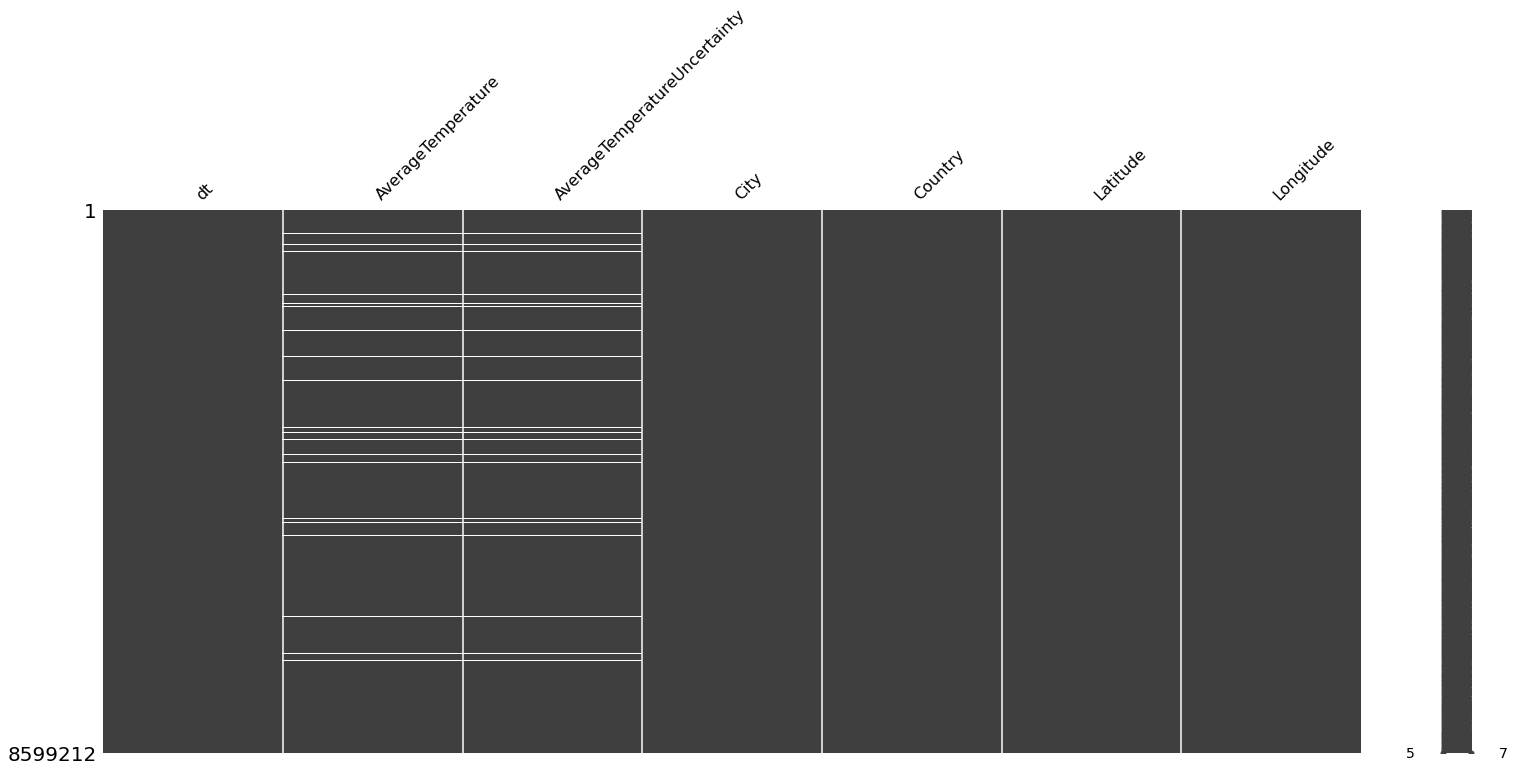

In [14]:
msno.matrix(weather_df)

In [15]:
missing_weather_values = weather_df[weather_df.isnull().any(axis = 1)]

In [16]:
#Before dropping lets see what our data should look like if we drop all na values
number_records_no_missing = weather_df.shape[0] - missing_weather_values.shape[0]
weather_df.dropna(inplace = True)
if number_records_no_missing == weather_df.shape[0]:
    print(f'Missing records successfully dropped, there are now {weather_df.shape[0]} records in weather_df')
else:
    print('Not all missing records were dropped')

Missing records successfully dropped, there are now 8235082 records in weather_df


In [17]:
num_duplicated = len(weather_df[weather_df.duplicated()].index)
print(f"There are {num_duplicated} duplicated rows")

There are 0 duplicated rows


In [18]:
#reset the index
weather_df.reset_index(inplace = True,drop = True)

<a id='gdp2'></a>
**View/Clean GDP**

In [19]:
gdp_df.head()

,Country Name,Country Code,Series Name,Series Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020]
0,Afghanistan,AFG,GDP per capita (constant 2010 US$),NY.GDP.PCAP.KD,..,..,..,..,..,..,...,528.737,576.19,587.565,583.656,574.184,571.074,571.441,564.61,573.288,..
1,Albania,ALB,GDP per capita (constant 2010 US$),NY.GDP.PCAP.KD,..,..,..,..,..,..,...,4209.87,4276.61,4327.38,4413.3,4524.37,4681.83,4864.31,5074.86,5210.69,..
2,Algeria,DZA,GDP per capita (constant 2010 US$),NY.GDP.PCAP.KD,2480.95,2090.75,1638.22,2146.24,2214.16,2289.91,...,4523.25,4586.66,4621.59,4700.64,4775.87,4828.63,4792.39,4753.51,4699.76,..
3,American Samoa,ASM,GDP per capita (constant 2010 US$),NY.GDP.PCAP.KD,..,..,..,..,..,..,...,10360.5,9921.81,9640.34,9717.83,9850.57,9589.98,9048.18,9271.71,..,..
4,Andorra,AND,GDP per capita (constant 2010 US$),NY.GDP.PCAP.KD,..,..,..,..,..,..,...,41191.8,39769.6,39143.7,40914.7,42141,44108,44430.7,45133.7,45887.3,..


In [20]:
#we do not need 'Series Name','Series Code','Country Code' only country, and gdp
gdp_df.drop(['Series Name','Series Code'], axis = 1, inplace = True)

In [21]:
#the three 3 columns above have been successfully dropped
gdp_df.columns

Index(['Country Name', 'Country Code', '1960 [YR1960]', '1961 [YR1961]',
       '1962 [YR1962]', '1963 [YR1963]', '1964 [YR1964]', '1965 [YR1965]',
       '1966 [YR1966]', '1967 [YR1967]', '1968 [YR1968]', '1969 [YR1969]',
       '1970 [YR1970]', '1971 [YR1971]', '1972 [YR1972]', '1973 [YR1973]',
       '1974 [YR1974]', '1975 [YR1975]', '1976 [YR1976]', '1977 [YR1977]',
       '1978 [YR1978]', '1979 [YR1979]', '1980 [YR1980]', '1981 [YR1981]',
       '1982 [YR1982]', '1983 [YR1983]', '1984 [YR1984]', '1985 [YR1985]',
       '1986 [YR1986]', '1987 [YR1987]', '1988 [YR1988]', '1989 [YR1989]',
       '1990 [YR1990]', '1991 [YR1991]', '1992 [YR1992]', '1993 [YR1993]',
       '1994 [YR1994]', '1995 [YR1995]', '1996 [YR1996]', '1997 [YR1997]',
       '1998 [YR1998]', '1999 [YR1999]', '2000 [YR2000]', '2001 [YR2001]',
       '2002 [YR2002]', '2003 [YR2003]', '2004 [YR2004]', '2005 [YR2005]',
       '2006 [YR2006]', '2007 [YR2007]', '2008 [YR2008]', '2009 [YR2009]',
       '2010 [YR2010]', '20

In [22]:
#drop missing values
gdp_df.dropna(inplace = True)

In [23]:
#hmm... although null values were dropped
#some missing values are not Null, they are represented by '..'
gdp_df[gdp_df['1960 [YR1960]'] == '..']

,Country Name,Country Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],1966 [YR1966],1967 [YR1967],...,2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020]
0,Afghanistan,AFG,..,..,..,..,..,..,..,..,...,528.737,576.19,587.565,583.656,574.184,571.074,571.441,564.61,573.288,..
1,Albania,ALB,..,..,..,..,..,..,..,..,...,4209.87,4276.61,4327.38,4413.3,4524.37,4681.83,4864.31,5074.86,5210.69,..
3,American Samoa,ASM,..,..,..,..,..,..,..,..,...,10360.5,9921.81,9640.34,9717.83,9850.57,9589.98,9048.18,9271.71,..,..
4,Andorra,AND,..,..,..,..,..,..,..,..,...,41191.8,39769.6,39143.7,40914.7,42141,44108,44430.7,45133.7,45887.3,..
5,Angola,AGO,..,..,..,..,..,..,..,..,...,3579.96,3748.45,3796.88,3843.2,3748.32,3530.31,3409.93,3233.91,3111.16,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,Vanuatu,VUT,..,..,..,..,..,..,..,..,...,2923.42,2893.1,2868.04,2853.48,2781.79,2803.77,2854,2864.83,2887.31,..
257,Vietnam,VNM,..,..,..,..,..,..,..,..,...,1385.89,1443.49,1505.81,1579.19,1667.17,1752.53,1852.96,1964.48,2082.24,..
258,Virgin Islands (U.S.),VIR,..,..,..,..,..,..,..,..,...,36798.7,31301,29516,29303.7,29408.1,29729.2,29290.8,..,..,..
259,West Bank and Gaza,PSE,..,..,..,..,..,..,..,..,...,2732.69,2828.62,2891.27,2819.82,2858.53,3042.81,3025.23,2985.76,2939.33,..


In [24]:
#replace .. with NaN
gdp_df.replace('..',np.nan, inplace = True)
#now we see the Null values are properly filled
gdp_df.head()

,Country Name,Country Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],1966 [YR1966],1967 [YR1967],...,2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020]
0,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,528.736648,576.190125,587.565090,583.656193,574.184114,571.073775,571.440691,564.609992,573.287551,NaN
1,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4209.874801,4276.607904,4327.379960,4413.296891,4524.373086,4681.826563,4864.310616,5074.857222,5210.688290,NaN
2,Algeria,DZA,2480.951371,2090.754416,1638.221364,2146.242205,2214.161947,2289.910395,2120.454544,2255.793029,...,4523.248437,4586.655185,4621.590589,4700.640563,4775.873295,4828.626059,4792.387242,4753.510987,4699.763405,NaN
3,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10360.509155,9921.806108,9640.344462,9717.829056,9850.565034,9589.979837,9048.182522,9271.712010,NaN,NaN
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41191.785412,39769.561458,39143.689681,40914.728524,42140.961798,44107.956331,44430.744009,45133.713615,45887.302126,NaN


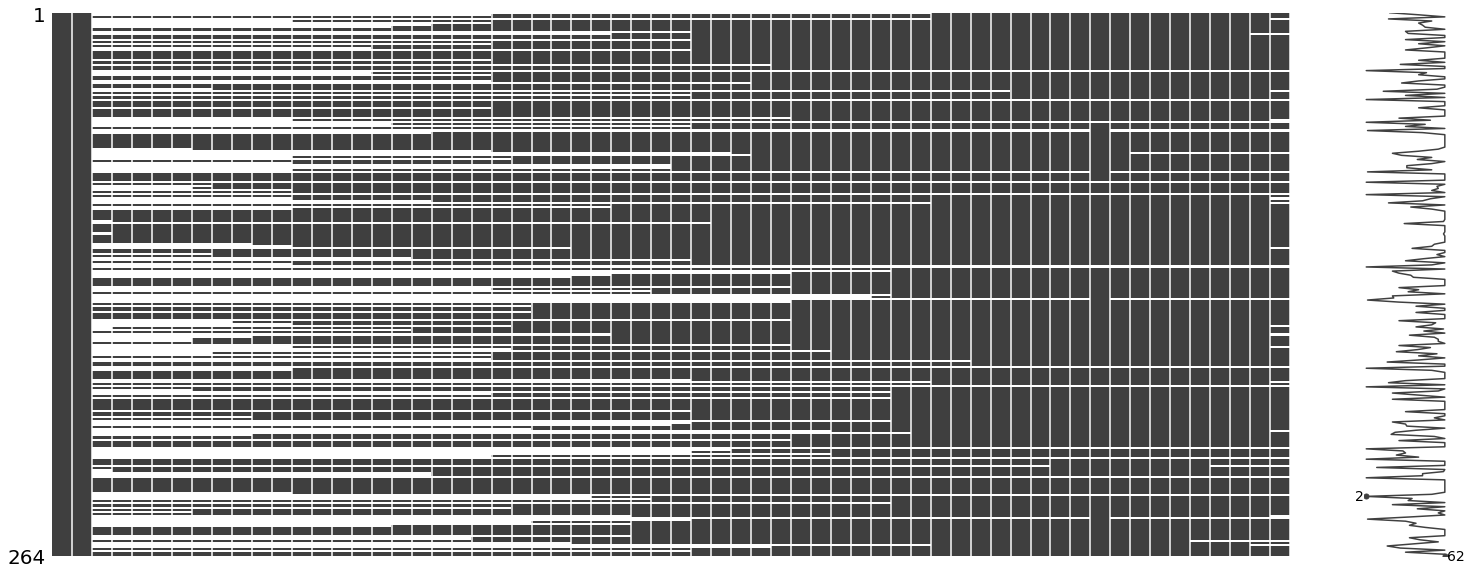

In [25]:
msno.matrix(gdp_df)

In [26]:
gdp_df = gdp_df.set_index(["Country Name", "Country Code"]).T.reset_index().melt(id_vars=['index']).copy()

In [27]:
#rename index to year
gdp_df.rename({'index':'year'},axis = 1, inplace = True)
#reformat year by removing [year] and turning it from an object to int
gdp_df['year'] = gdp_df['year'].str.replace(r'\[(\w)+\]','').astype(int)

In [28]:
#drop the remaining missing values
gdp_df.dropna(inplace = True)
gdp_df.reset_index(inplace = True, drop = True)

In [29]:
gdp_df.head()

,year,Country Name,Country Code,value
0,2002,Afghanistan,AFG,330.303553
1,2003,Afghanistan,AFG,343.080890
2,2004,Afghanistan,AFG,333.216684
3,2005,Afghanistan,AFG,357.234720
4,2006,Afghanistan,AFG,365.284495


<a id='b5_2'></a>   

**View/Clean Big Five Personality**

In [30]:
b5_df.count()

1015341

In [31]:
len(b5_df.columns)

110

In [32]:
#drop null values
b5_df = b5_df.dropna()

In [33]:
b5_df.take(1)

[Row(EXT1='4', EXT2='1', EXT3='5', EXT4='2', EXT5='5', EXT6='1', EXT7='5', EXT8='2', EXT9='4', EXT10='1', EST1='1', EST2='4', EST3='4', EST4='2', EST5='2', EST6='2', EST7='2', EST8='2', EST9='3', EST10='2', AGR1='2', AGR2='5', AGR3='2', AGR4='4', AGR5='2', AGR6='3', AGR7='2', AGR8='4', AGR9='3', AGR10='4', CSN1='3', CSN2='4', CSN3='3', CSN4='2', CSN5='2', CSN6='4', CSN7='4', CSN8='2', CSN9='4', CSN10='4', OPN1='5', OPN2='1', OPN3='4', OPN4='1', OPN5='4', OPN6='1', OPN7='5', OPN8='3', OPN9='4', OPN10='5', EXT1_E='9419', EXT2_E='5491', EXT3_E='3959', EXT4_E='4821', EXT5_E='5611', EXT6_E='2756', EXT7_E='2388', EXT8_E='2113', EXT9_E='5900', EXT10_E='4110', EST1_E='6135', EST2_E='4150', EST3_E='5739', EST4_E='6364', EST5_E='3663', EST6_E='5070', EST7_E='5709', EST8_E='4285', EST9_E='2587', EST10_E='3997', AGR1_E='4750', AGR2_E='5475', AGR3_E='11641', AGR4_E='3115', AGR5_E='3207', AGR6_E='3260', AGR7_E='10235', AGR8_E='5897', AGR9_E='1758', AGR10_E='3081', CSN1_E='6602', CSN2_E='5457', CSN3_

<a id ='cc2'></a>  
**View/Clean Country Codes**

In [35]:
cc_df.isnull().sum()

Country         0
Alpha-2 code    0
Alpha-3 code    0
Numeric         0
dtype: int64

In [34]:
cc_df.head()

,Country,Alpha-2 code,Alpha-3 code,Numeric
1,Afghanistan,AF,AFG,004
2,Åland Islands,AX,ALA,248
3,Albania,AL,ALB,008
4,Algeria,DZ,DZA,012
5,American Samoa,AS,ASM,016


<a id = 'define'></a>
## 4. Define Database Schema
* The model is shown below.
* The data consists of 2 snowflake schemas. Where the 5 different personality traits are connected by an index to the scored personalities. The scored personalities are connected to country codes. The GDP and Weather are also connected to the country codes.
* The Data Pipeline:
> Extracting data from the original datasets, transforming the data such as ( feature engineering, and changing data types), then loading the finalized dataframes into a sqlite database.

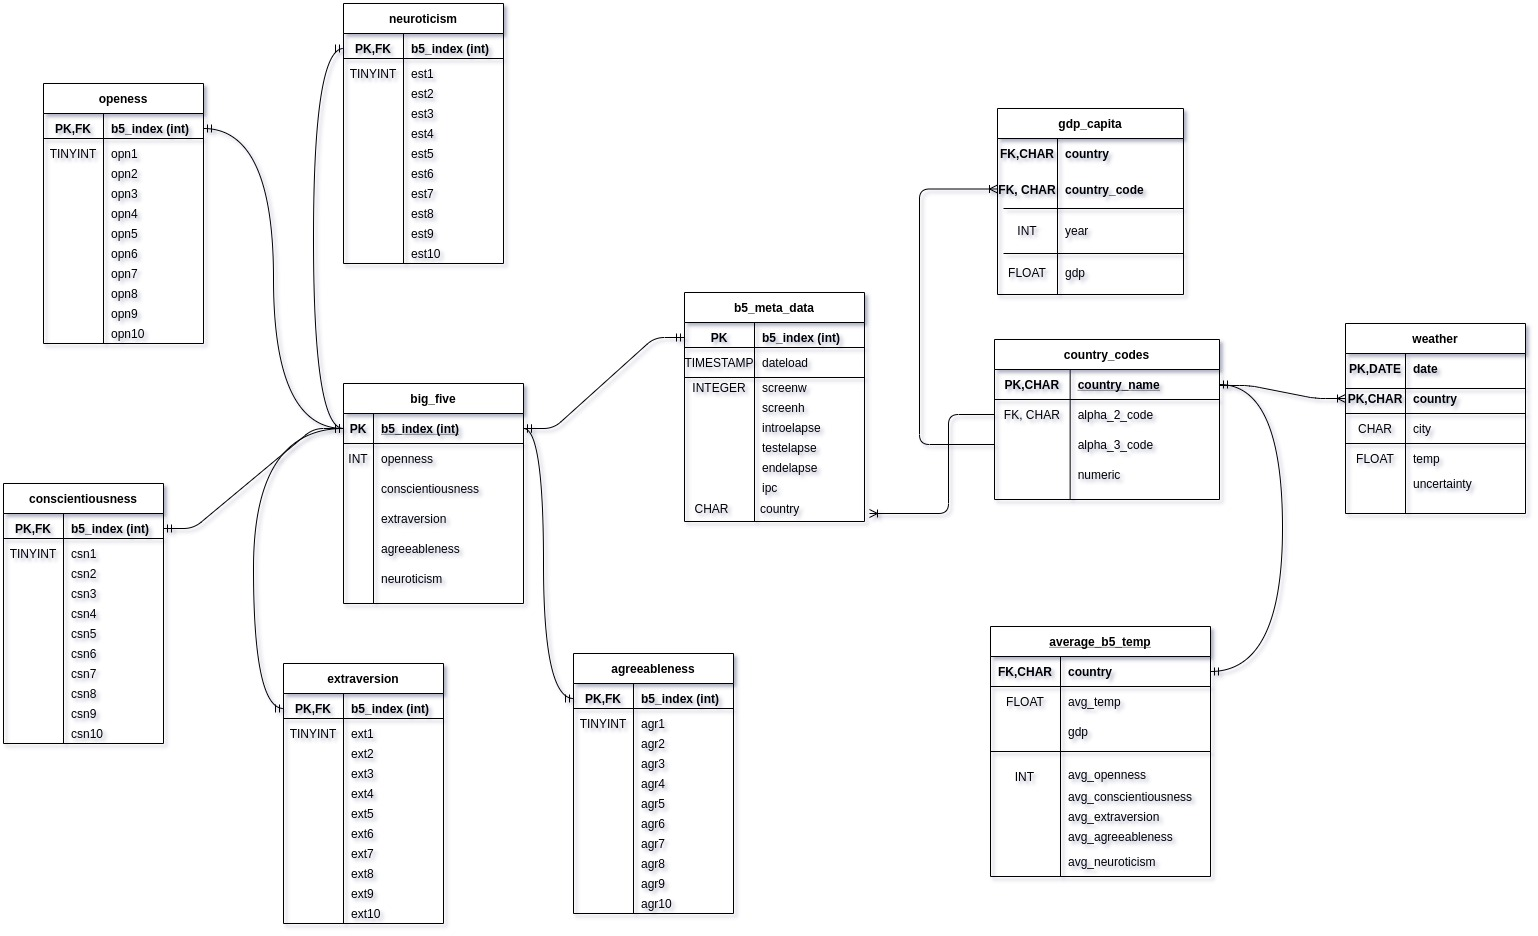

In [91]:
Image('er (3).jpg',width=800, height=100)

<a id ='etl'></a>
## 4. Run Pipelines to Model the Data 
1. Extract data from the Big Five Personalities
    * [Feature Engineering](#b5_2_1)  
    > From the original dataset create 7 more.  
    > 5 for each personality, 1 for calculated scores, 1 for meta data.
2. [Create](#create) the tables that will be used in the database
3. [Insert](#insert) the data that will be used in the data base

<a id = 'b5_2_1'></a>
**Feature engineering**
* Create 5 different personality tables
* Create an aggregated score for each personality table according to the formula provided
* Create meta data table

In [36]:
#create an index which will be used for the primary key
b5_df = b5_df.select('*').withColumn("b5_index", monotonically_increasing_id()+1)

In [37]:
#create pyspark dataframe for each of the 5 personalities, and set the type to int
def create_b5_df(df, cols):
    new_df = df.select(*(col(c).cast('int').alias(c) for c in cols),'b5_index')
    return new_df

#get the column names for each personality group
extraversion = b5_df.columns[0:10]
neuroticism = b5_df.columns[10:20]
agreeableness = b5_df.columns[20:30]
conscientiousness = b5_df.columns[30:40]
openness = b5_df.columns[40:50]

extraversion_df = create_b5_df(b5_df,extraversion)
neuroticism_df =  create_b5_df(b5_df,neuroticism)
agreeableness_df = create_b5_df(b5_df,agreeableness)
conscientiousness_df = create_b5_df(b5_df,conscientiousness)
openness_df = create_b5_df(b5_df,openness)

In [38]:
#calculate the personalities score for each individual personality
#'https://openpsychometrics.org/printable/big-five-personality-test.pdf'

b5_df.createOrReplaceTempView("b5")
b5_scored = spark.sql(""" 
            SELECT 
                b5_index,
                20 + EXT1 - EXT2 + EXT3 - EXT4 + EXT5 - EXT6 + EXT7 - EXT8 + EXT9 - EXT10 as extraversion,
                14 - AGR1 + AGR2 - AGR3 + AGR4 - AGR5 + AGR6 - AGR7 + AGR8 + AGR9 + AGR10 as agreeableness,
                14 + CSN1 - CSN2 + CSN3 - CSN4 + CSN5 - CSN6 + CSN7 - CSN8 + CSN9 + CSN10 as conscientiousness,
                38 - EST1 + EST2 - EST3 + EST4 - EST5 - EST6 - EST7 - EST8 - EST9 - EST10 as neuroticism,
                8 +  OPN1 - OPN2 + OPN3 - OPN4 + OPN5 - OPN6 + OPN7 + OPN8 + OPN9 + OPN10 as openness 
            FROM b5
            """)

In [39]:
b5_scored.take(5)

[Row(b5_index=1, extraversion=36.0, agreeableness=29.0, conscientiousness=22.0, neuroticism=26.0, openness=35.0),
 Row(b5_index=2, extraversion=10.0, agreeableness=34.0, conscientiousness=27.0, neuroticism=25.0, openness=25.0),
 Row(b5_index=3, extraversion=15.0, agreeableness=32.0, conscientiousness=24.0, neuroticism=24.0, openness=31.0),
 Row(b5_index=4, extraversion=16.0, agreeableness=28.0, conscientiousness=15.0, neuroticism=21.0, openness=29.0),
 Row(b5_index=5, extraversion=19.0, agreeableness=36.0, conscientiousness=38.0, neuroticism=31.0, openness=38.0)]

In [40]:
b5_meta_data = ['dateload', 'screenw', 'screenh', 'introelapse', 'testelapse', 'endelapse','IPC', 'country']

In [41]:
b5_df.select(b5_meta_data).dtypes

[('dateload', 'string'),
 ('screenw', 'string'),
 ('screenh', 'string'),
 ('introelapse', 'string'),
 ('testelapse', 'string'),
 ('endelapse', 'string'),
 ('IPC', 'string'),
 ('country', 'string')]

In [42]:
#correct the data types from string to int
b5_meta_df = b5_df.select('b5_index', *(col(c).cast('int').alias(c) for c in b5_meta_data[:-1]), 'country')

In [43]:
b5_meta_df.take(5)

[Row(b5_index=1, dateload=None, screenw=768, screenh=1024, introelapse=9, testelapse=234, endelapse=6, IPC=1, country='GB'),
 Row(b5_index=2, dateload=None, screenw=1360, screenh=768, introelapse=12, testelapse=179, endelapse=11, IPC=1, country='MY'),
 Row(b5_index=3, dateload=None, screenw=1366, screenh=768, introelapse=3, testelapse=186, endelapse=7, IPC=1, country='GB'),
 Row(b5_index=4, dateload=None, screenw=1920, screenh=1200, introelapse=186, testelapse=219, endelapse=7, IPC=1, country='GB'),
 Row(b5_index=5, dateload=None, screenw=1366, screenh=768, introelapse=8, testelapse=315, endelapse=17, IPC=2, country='KE')]

<a id = 'create'></a>
**Creation**

In [44]:
def create_table(table_name, col_names, query, db_name = 'b5_personality.db'):
    
    conn = sqlite3.connect(db_name)
    c = conn.cursor()
    
    c.execute(query.format(table_name, (*[n.lower() for n in col_names])))
    conn.commit()
    conn.close()

In [45]:
#create weather
create_weather_table =\
    """
        CREATE TABLE IF NOT EXISTS {}
        ({} timestamp, {} str, {} str, {} real, {} real)
    """
create_table('weather', col_names = ['date','country','city','temp','temp_uncertainty'],\
             query = create_weather_table)

In [46]:
#create gdp table
create_gdp_table =\
    """
        CREATE TABLE IF NOT EXISTS {}
        ({} str, {} str, {} int, {} real)
    """
create_table('gdp_capita', col_names = ['country','country_code','year','gdp'],query = create_gdp_table)

In [47]:
b5_table_names = ['openness','conscientiousness','extraversion','agreeableness','neuroticism']
b5_col_names = [openness, conscientiousness, extraversion, agreeableness, neuroticism]

#create personality tables
create_personality_table =\
    """
        CREATE TABLE IF NOT EXISTS {}
        (b5_index int, {} int,{} int,{} int,{} int,{} int,{} int,{} int,{} int,{} int,{} int) 
    """
for tn, cn in list(zip(b5_table_names, b5_col_names)):
    create_table(tn,cn,create_personality_table)

#create big_five table
create_big_five_table =\
    """
        CREATE TABLE IF NOT EXISTS {}
        (big5_index int, {} int, {} int, {} int, {} int, {} int)
    """
create_table('big_five',col_names = b5_table_names, query= create_big_five_table)

#create b5_meta_data
create_b5_meta_table =\
    """
        CREATE TABLE IF NOT EXISTS {}
        (big5_index int, {} datetime, {} int, {} int, {} int, {} int, {} int, {} int, {} str )
    """
create_table('b5_meta_data', col_names = b5_meta_data, query = create_b5_meta_table)

In [48]:
#create country_codes table
create_cc_table = \
    """
        CREATE TABLE IF NOT EXISTS {}
        ({} str, {} str, {} str, {} str)
    """
create_table('country_codes', col_names = ['country_names','alpha_2','alpha_3','numeric'],query = create_cc_table)

<a id ='insert'></a>
**Insertion**

In [49]:
def insert_to_sql(df, table_name, db_name = 'b5_personality.db'):
    
    conn = sqlite3.connect(db_name)    
    df.to_sql(table_name, conn, if_exists = 'replace', index =False)
    conn.close()

In [50]:
weather_df = weather_df[['dt','Country','City', 'AverageTemperature','AverageTemperatureUncertainty']]

#rename columns
rename_weather_cols = {'dt':'date', 'Country':'country', 'City':'city',\
                       'AverageTemperature': 'temp','AverageTemperatureUncertainty': 'temp_uncertainty'}


weather_df.rename(rename_weather_cols, axis = 1, inplace = True)

#insert to sql
insert_to_sql(weather_df, 'weather')

In [51]:
rename_gdp_cols = {'Country Name':'country','Country Code':'country_code','value':'gdp'}
gdp_df.rename(rename_gdp_cols,axis =1, inplace = True)
insert_to_sql(gdp_df,'gdp_capita')

In [52]:
rename_cc_cols = {'Country':'country_names', 'Alpha-2 code':'alpha_2', \
                  'Alpha-3 code':'alpha_3', 'Numeric':'numeric'}

cc_df.rename(rename_cc_cols, axis = 1, inplace = True)

#insert to sql
insert_to_sql(cc_df, 'country_codes')

In [53]:
def col_name_2_lowercase(df):
    for c in df.columns:
        df = df.withColumnRenamed(c, c.lower())
    return df

In [54]:
openness_df = col_name_2_lowercase(openness_df)
conscientiousness_df = col_name_2_lowercase(conscientiousness_df)
extraversion_df = col_name_2_lowercase(extraversion_df)
agreeableness_df = col_name_2_lowercase(agreeableness_df)
neuroticism_df = col_name_2_lowercase(neuroticism_df)

In [83]:
insert_to_sql(openness_df.toPandas(),'openness')
insert_to_sql(conscientiousness_df.toPandas(), 'conscientiousness')
insert_to_sql(extraversion_df.toPandas(), 'extraversion')
insert_to_sql(agreeableness_df.toPandas(), 'agreeableness')
insert_to_sql(neuroticism_df.toPandas(),'neuroticism')

KeyboardInterrupt: 

In [57]:
insert_to_sql(b5_scored.toPandas(),'big_five')
insert_to_sql(b5_meta_df.toPandas(),'b5_meta_data')

<a id = 'dq'></a>
## 5. Data Quality Checks 
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

**Check count for quality check**

In [71]:
def count_check(table_name, db ='b5_personality.db'):
    conn = sqlite3.connect(db)
    c = conn.cursor()
    c.execute("SELECT COUNT(*) FROM {}".format(table_name))
    num_rows =  c.fetchall()[0][0]
    conn.close()
    return num_rows

In [73]:
#check to see if the b5_scored spark df has the same records as the table in the database.
print(b5_scored.count() == count_check('big_five'))

True


In [75]:
b5_scored.dtypes

[('b5_index', 'bigint'),
 ('extraversion', 'double'),
 ('agreeableness', 'double'),
 ('conscientiousness', 'double'),
 ('neuroticism', 'double'),
 ('openness', 'double')]

**datatype check**

In [76]:
def dtype_check(table_name, db ='b5_personality.db'):
    conn = sqlite3.connect(db)
    c = conn.cursor()
    c.execute("PRAGMA table_info({})".format(table_name))
    num_rows =  c.fetchall()
    conn.close()
    return num_rows

In [78]:
dtype_check('weather')

[(0, 'date', 'TIMESTAMP', 0, None, 0),
 (1, 'country', 'TEXT', 0, None, 0),
 (2, 'city', 'TEXT', 0, None, 0),
 (3, 'temp', 'REAL', 0, None, 0),
 (4, 'temp_uncertainty', 'REAL', 0, None, 0)]

In [81]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8235082 entries, 0 to 8235081
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   country           object        
 2   city              object        
 3   temp              float64       
 4   temp_uncertainty  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 314.1+ MB


<a id = 'dictionary'></a>
## 6. Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

|Table Name| # of cols  |Description|
|----------|------------|-------|
|openness  | 11 |This trait features characteristics such as imagination and insight.|
|conscientiousness|11|Standard features of this dimension include high levels of thoughtfulness, good impulse control, and goal-directed behaviors.|
|extraversion|11| Characterized by excitability, sociability, talkativeness, assertiveness, and high amounts of emotional expressiveness.|
|agreeableness|11|This personality dimension includes attributes such as trust, altruism, kindness, affection, and other prosocial behaviors.|
|neuroticism|11|Traits characterized by sadness, moodiness, and emotional instability.|
|big_five| 6| The sum of the scored values of each personality.|
|b5_meta_data|9| Meta data collected for the big 5 personality survey.|
|country_codes|4| Country Names and their respective codes.|
|gdp_capita|4| The gdp per capita for different countries.|
|weather|5| The average temperature for each city and country.|

<a id='rationale'></a>
## 7. Rationale

1. Tools and Reasonings:
    * pyspark was used to query and feature engineer the tables with more than 1 million records. 
    * sqlite was used as the database because it is easy to use and store locally. 
  -----
2. How often should this be updated?:  

    * The data should be updated once every year because we want to know the yearly weather patterns, and gdp per capita.    
    ------
    
3. Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x:   
 
     * If the data was increased by 100x, we will use pyspark for all the tables not just the ones with more than 1 million records.  
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
     * If the data needs to be updated daily, then we should implement an airflow pipeline to automate the process.  
 * The database needed to be accessed by 100+ people.
     * if the data needs to be accessed by 100+ people a different database should be used such as AWS redshift.